# Notebook evaluating metrics for particular node/edge configuration

In [1]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [2]:
## Define variables
# Label imports
groundTruth = "./data/beirutDamages.shp" # Damages shapefile
crs = 'EPSG:4326' # Coordinate system to be used
cn = 'decision' # Column for classes
splitString = False # Only use first word in class column
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Data imports
dataTypes = ['hr','ifg']
hrPreFile = "data/highRes/20JUL31_HR_LatLon.tif" # High Res image Pre
hrPostFile = "data/highRes/20AUG05_HR_LatLon.tif" # High resolution img Post
crsHr = 'epsg:4326'
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
crsIfg = 'epsg:4326'

# Map filtering of location
lat, lon, zoom = 33.893, 35.512, 14 # Map properties
stdTest = False # Use standard area for Beirut testing
max_nodes = 20000

# Class options
nClasses = False # Enforce number of classes (False -> # classes in labels)
classNames = False #['Undamaged','Damaged'] # Enforce names of classes (False -> cl0, cl1,...)
classAssign = False #[['GREEN','LAND'],['YELLOW','RED','TOTAL']] # Enforce class grouping (False -> Clustering is performed)
pca, pcaComps, meanCluster = False, 2, True # Clustering properties if used

# Edge creation
adjacent, geoNeighbours = False, 4 # geographical edges, n neighbours
phase, neighbours = True, [3,3] # Data value edges, n neighbours for each data type

In [3]:
## Import Labels and combine
labels = ip.shape_to_gdf(groundTruth, splitString, cn, crs=crs)

# Display map of assessments upon which to draw Polygon for analysis
m1 = pl.create_map(lat, lon, zoom)
m1 = pl.plot_assessments(labels, m1)
m1, testPoly = pl.draw_polygon(labels, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [4]:
# Change coordinate system if not crs
import rasterio as ro
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

for i in dataTypes:
    if crs not in str(ro.open(globals()[i + 'PostFile']).crs):
        for num, file in enumerate([globals()[i + 'PreFile'], globals()[i + 'PostFile']]):
            try:
                with rasterio.open(file) as src:
                    transform, width, height = calculate_default_transform(
                        src.crs, crs, src.width, src.height, *src.bounds)
                    kwargs = src.meta.copy()
                    kwargs.update({
                        'crs': crs,
                        'transform': transform,
                        'width': width,
                        'height': height
                    })

                with rasterio.open(["data/"+i+"PreConv.tif","data/"+i+"PostConv.tif"][num], 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=dst_crs,
                            resampling=Resampling.nearest)
            except: pass
        globals()[i + 'PreFile'], globals()[i + 'PostFile'] = "data/"+i+"PreConv.tif","data/"+i+"PostConv.tif" 

In [5]:
# Data Imports
# Import first data type
PreGdf, crop = ip.img_to_gdf(globals()[dataTypes[0]+'PreFile'], testPoly, crs=crs)#,  columns=dataTypes[1])
PostGdf, _ = ip.img_to_gdf(globals()[dataTypes[0]+'PostFile'], testPoly, crs=crs)#,  columns=dataTypes[1])
gdf = hf.subtract_gdfs(PostGdf, PreGdf)
typesUsed = [list(gdf.columns.drop('geometry').values), dataTypes[1:]]
crop.rio.to_raster("croptemp.tif")

# Resample other data types to first
import rioxarray as rxr
import rasterio as ro
import shapely.geometry as sg
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
import resample
import os

def resample_tif(file, testPoly, out):
    img = rxr.open_rasterio(file, masked=True).squeeze()
    _, extent = hf.get_extent(testPoly)
    imgCrop = img.rio.clip(extent.geometry.apply(sg.mapping))   
    imgNm = imgCrop.rename('img')
    imgNm.rio.to_raster(out)

def tif_to_array(tifFile, cropFile):
        tif, b = ro.open(tifFile), cropFile.data.labelled_bounds
        array = tif.read(window=from_bounds(b[0],b[1],b[2],b[3],transform=tif.transform),
                         out_shape=(tif.count, cropFile.data.height, cropFile.data.width),
                         resampling=Resampling.bilinear)
        tif.close()
        return array.copy()

if len(dataTypes) > 1:
    for i, tp in enumerate(dataTypes[1:]):
        resample_tif(globals()[tp+'PostFile'], testPoly, tp+'Posttemp.tif')
        globals()[tp+'Array'] = tif_to_array(tp+'Posttemp.tif', resample)
        if tp+'PreFile' in locals(): 
            resample_tif(globals()[tp+'PreFile'], testPoly, tp+'Pretemp.tif')
            globals()[tp+'Array'] -= tif_to_array(tp+'Pretemp.tif', resample)

for item in os.listdir("."): 
    if item.endswith("temp.tif"): os.remove(item)
        
# Concatenate data types
data = gdf.copy()
for tp in dataTypes[1:]: data[tp]=globals()[tp+'Array'].flatten()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2940: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return runner(coro)


In [6]:
# Assign Label classes to data
defClasses, labelsUsed, dataUsed = len(labels[cn].unique()), labels.to_crs(crs).copy(), data.copy() # Default classes from labels
usedNames = labels[cn].unique() if nClasses==defClasses or nClasses is False else classNames
initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs) # Initial class value for each data pixel

if not nClasses: nClasses = defClasses # If default classes used
elif nClasses > defClasses: raise NameError('Cannot assign more classes than in original data') # If invalid input
elif nClasses < defClasses: # Perform class grouping
    if not classAssign: # Perform clustering
        # Assign labels to each pixel
        allPixels = hf.create_nodes(initial, labelsUsed[['geometry',cn]][labelsUsed.within(poly)])
        # Run PCA if set to True
        X = hf.run_PCA(dataUsed[dataTypes[0]].values.transpose(), pcaComps).components_.transpose() if pca else dataUsed[dataTypes[0]]
        # Run clustering
        kmeans, clusterClasses, initLabels = hf.run_cluster(X[allPixels[cn].dropna().index].values.reshape(-1,1), allPixels[cn].dropna(), meanCluster, nClasses)
        print('Clustered classes:{} , original classes:{}'.format(clusterClasses, initLabels))
        # Create groups of classes
        classesUsed = []
        for j in range(nClasses): classesUsed.append([initLabels[i] for i, x in enumerate(list(clusterClasses)) if x==j])
    else: 
        classesUsed = classAssign
        #used = [i in flatten_list(classesUsed) for i in labelsUsed[cn]]
        initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs)
    # Assign labels for each pixel after clustering
    labelsUsed[cn] = hf.group_classes(labelsUsed[cn], classesUsed)

In [7]:
import random
# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, hf.get_polygon(testPoly, conv=True))
# Create nodes
samples = initial.copy().iloc[random.sample(range(0, initial.shape[0]), max_nodes)].reset_index(drop=True) if len(initial) > max_nodes else intial.copy()

nodes = hf.create_nodes(samples, X_train)
#nodesamples = nodes.copy().iloc[random.sample(range(0, nodes.shape[0]), max_nodes)] if len(nodes) > max_nodes else nodes.copy()

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses:], classNames=classNames, column = cn)

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=typesUsed , neighbours=neighbours)

/opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != EPSG:4326)
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [8]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-3)

Nodes: 20000, Edges: 120000
It	Loss	Label change

0	4.68523e-01		7747

1	1.74278e-01		906

2	7.94079e-02		229

3	3.42321e-02		86

4	1.67130e-02		46

5	7.61013e-03		23

6	3.57950e-03		13

7	1.71347e-03		6

8	8.06865e-04		0

Time elapsed: 18.30380153656006 seconds


/opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != EPSG:4326)
  '(%s != %s)' % (left_df.crs, right_df.crs))


['GREEN' 'YELLOW' 'LAND' 'RED' 'TOTAL']
              precision    recall  f1-score   support

       GREEN       0.51      0.75      0.61      1663
        LAND       0.09      0.03      0.04       156
         RED       0.43      0.24      0.30       712
       TOTAL       0.20      0.02      0.03       176
      YELLOW       0.32      0.25      0.28       887

    accuracy                           0.46      3594
   macro avg       0.31      0.26      0.25      3594
weighted avg       0.41      0.46      0.41      3594



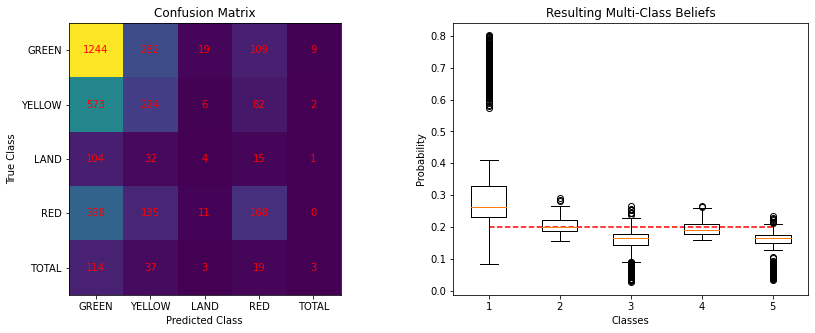

In [10]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(samples, X_test, beliefs, column=cn)

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=classNames)

fig, axs = pl.create_subplots(1,2, figsize=[14,5])

# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], y_true, y_pred)

pl.show_plot()

In [11]:
# Save figure
pl.save_plot(fig, 'results/Beirut_UN_adj{}{}_tp{}_neighbours{}_cl{}_std{}'.format(str(adjacent),str(geoNeighbours),str(dataTypes),str(neighbours),str(nClasses),str(stdTest)))

In [ ]:
# Visualise spatial results
fig, axs = pl.create_subplots(2,2,figsize=[15,12])

prePlot = pl.belief_plot(nodes, axs[0,0], 'RED', normalise=False)
postPlot = pl.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (pl.cropped_ifg(ifgPreFile,testPoly)-pl.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

pl.show_plot()